In [1]:
import copy

import numpy as np

import cytoxnet.models.models
import cytoxnet.dataprep.io
import cytoxnet.dataprep.featurize
import cytoxnet.dataprep.dataprep
import importlib
import matplotlib.pyplot as plt

# Ivestigate transfering data across datasets

## get and prepare data

Get data

In [2]:
## loading a dataset
data_raw = cytoxnet.dataprep.io.load_lunghini(nans='keep')
data_raw.describe()

,algea_EC50,fish_LC50,daphnia_EC50
count,1440.000000,2199.000000,2120.000000
mean,118.942882,202.975335,62.426641
std,596.983371,1308.709203,632.706477
min,0.000395,0.000130,0.000000
25%,3.200000,1.800000,1.000000
50%,15.000000,9.400000,6.455000
75%,56.325000,52.000000,31.075000
max,9120.000000,37700.000000,25000.000000


Take the log

In [3]:
def log_trans(row):
    inp = row.values.reshape(-1)
    out = []
    for val in inp:
        if not np.isnan(val):
            val_ = np.log(val)
            if np.isinf(val_):
                out.append(np.nan)
            else:
                out.append(val_)
        else:
            out.append(val)
    return out

In [4]:
data_raw[['algea_EC50', 'fish_LC50', 'daphnia_EC50']] = data_raw[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].apply(log_trans)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Add features

In [6]:
data_all = cytoxnet.dataprep.featurize.molstr_to_Mol(data_raw, 'smiles')
data_all = cytoxnet.dataprep.featurize.add_features(data_all, method='ConvMolFeaturizer')

Pop some algea examples to act as a global test set

In [7]:
dataframe_algea_test = data_all[~data_all['algea_EC50'].isnull()].sample(frac=0.2)
dataframe_all_dev = data_all.drop(dataframe_algea_test.index, axis=0)

Make add weights for sparsity data

In [8]:
dataframe_all_dev['w'] = list(np.float64(
        ~dataframe_all_dev[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].isnull().values
    )
)
dataframe_algea_test['w'] = list(np.float64(
        ~dataframe_algea_test[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].isnull().values
    )
)

Create some deepchem datasets to use

In [9]:
# algea global test set
algea_test = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_algea_test,
    X_col = ['ConvMolFeaturizer'],
    y_col = 'algea_EC50'
)
# need this test set with all 3 tasks for multitask
dataframe_algea_test_ = dataframe_algea_test.fillna(0.0)
algea_test_multi = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_algea_test_,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['algea_EC50', 'fish_LC50', 'daphnia_EC50'],
    w_col = 'w'
)
# algea train set - the algea indexes in the dev set
algea_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev[~dataframe_all_dev['algea_EC50'].isnull()],
    X_col = ['ConvMolFeaturizer'],
    y_col = 'algea_EC50'
)
# a fish dataset
fish_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev[~dataframe_all_dev['fish_LC50'].isnull()],
    X_col = ['ConvMolFeaturizer'],
    y_col = 'fish_LC50'
)
# a multitasker of all but the algea test
# first replace nans
dataframe_all_dev_ = dataframe_all_dev.fillna(0.0)
multi_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev_,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['algea_EC50', 'fish_LC50', 'daphnia_EC50'],
    w_col = 'w'
)

## Train a baseline model on just algea data

In [118]:
baseline = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression')

Let's use 150 epochs as a baseline.

In [119]:
train_losses = []
test_losses = []
for iteration in range(15):
    train_losses.append(baseline.fit(algea_train, nb_epoch=10))
    test_losses.append(baseline.fit(algea_test, checkpoint_interval=0))
    baseline.model.restore()

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_14:0", shape=(310,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_13:0", shape=(310, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_17:0", shape=(1278,), dtype=int32), values=Tensor("gradi

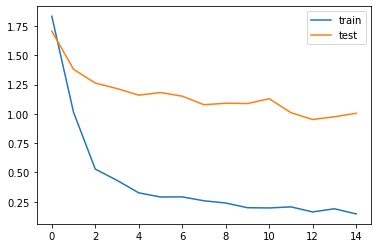

In [120]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(test_losses, label='test')
plt.legend()

In [121]:
baseline.evaluate(algea_test, metrics=['r2_score'])

{'metric-1': 0.4275586555237795}

In [122]:
baseline.visualize('pair_predict', algea_test, untransform=False)

(288, 1)


alt.LayerChart(...)

## Lets try a raw transfer from fish data
This involves no layer fixing - just retrain on a new dataset.

In [27]:
fish_pretrain = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression')

Pretrain on fish data 300 epochs

In [28]:
train_losses = []
test_losses = []
for iteration in range(30):
    train_losses.append(fish_pretrain.fit(fish_train, nb_epoch=10))
#     test_losses.append(fish_pretrain.fit(algea_test, checkpoint_interval=0))
#     baseline.model.restore()

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_14:0", shape=(372,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_13:0", shape=(372, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_17:0", shape=(1252,), dtype=int32), values=Tensor("gradient_tape

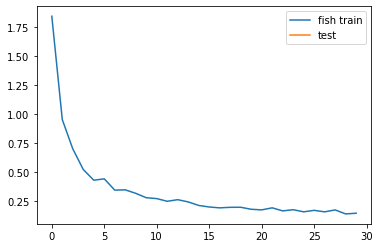

In [29]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='fish train')
ax.plot(test_losses, label='test')
plt.legend()

Transfer to algea and monitor loss

In [ ]:
train_losses = []
test_losses = []
for iteration in range(15):
    train_losses.append(fish_pretrain.fit(algea_train, nb_epoch=10))
#     test_losses.append(fish_pretrain.fit(algea_test, checkpoint_interval=0))
#     baseline.model.restore()

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='algea train')
ax.plot(test_losses, label='test')
plt.legend()

In [ ]:
fish_pretrain.evaluate(algea_test, metrics=['r2_score'])

In [ ]:
fish_pretrain.visualize('pair_predict', algea_test, untransform=False)

### Is this result simply because of highly correlated targets or was the training truly necessary?

In [12]:
## the correlation coefficient between the two targets
data_all.corr()

,algea_EC50,fish_LC50,daphnia_EC50
algea_EC50,1.000000,0.727654,0.660334
fish_LC50,0.727654,1.000000,0.763336
daphnia_EC50,0.660334,0.763336,1.000000


### They are indeed highly correlated. Does our training perform better than leverging this linearity?

In [13]:
fish_pretrain = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression')
fish_pretrain.fit(fish_train, nb_epoch=300)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(342,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(342, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(1230,), dtype=int32), values=Tensor("gradient_tape/private

0.13258301734924316

Prepare a linear transformer from fish predictions to algea predictions.

In [16]:
training_fish_predictions = fish_pretrain.predict(algea_train)

In [21]:
import sklearn.linear_model
import sklearn.metrics

In [19]:
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(training_fish_predictions, algea_train.y)

LinearRegression()

Make algea predictions with the fish transformer and evaluate the model

In [20]:
testing_fish_predictions = fish_pretrain.predict(algea_test)
testing_algea_predictions = linear_model.predict(testing_fish_predictions)

In [22]:
sklearn.metrics.r2_score(algea_test.y, testing_algea_predictions)

0.45612751695372145

The score is better than the baseline but not nearly as good as the transfer model! This means that the transfer training was effective.

## Try a sparse multitask predictor and see how well it does on algea

In [144]:
multitask_model = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression',
    tasks=['algea_EC50', 'fish_LC50', 'daphnia_EC50']
)

In [145]:
multitask_model.fit(multi_train, nb_epoch=150)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_15/graph_pool_31/Reshape_14:0", shape=(419,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_15/graph_pool_31/Reshape_13:0", shape=(419, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_15/graph_pool_31/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_15/graph_pool_31/Reshape_17:0", shape=(1346,), dtype=int32), values=Tensor("gradi

0.16921171188354492

In [147]:
multitask_model.evaluate(algea_test_multi,
                         metrics=['r2_score'],
                         per_task_metrics=True,
                         use_sample_weights=True)

({'metric-1': 0.3838519517140185},
 {'metric-1': [0.3531817834264357, 0.46044654907151594, 0.33792752264410386]})

In [148]:
multitask_model.visualize('pair_predict', algea_test_multi, untransform=False, task='algea_EC50')

(288, 3)


alt.LayerChart(...)

## It did not improve much. Let's get some other species involved

In [5]:
import pandas as pd

In [6]:
lunghini_fish = cytoxnet.dataprep.io.load_lunghini(species=['fish'])
lunghini_daphnia = cytoxnet.dataprep.io.load_lunghini(species=['daphnia'])
lunghini_algea = cytoxnet.dataprep.io.load_lunghini(species=['algea'])
zhu_rat = cytoxnet.dataprep.io.load_zhu_rat()
chembl_ecoli = cytoxnet.dataprep.io.load_chembl_ecoli()

In [7]:
# a bit of prep
chembl_ecoli.rename(columns={'MIC': 'ecoli_MIC'}, inplace=True)
zhu_rat.rename(columns={'LD50': 'rat_LD50'}, inplace=True)

In [8]:
sum_len = 0
dataframe = pd.DataFrame(columns=['smiles'])
for new_set in [lunghini_fish,
                lunghini_daphnia,
                lunghini_algea,
                zhu_rat,
                chembl_ecoli]:
    dataframe = dataframe.merge(new_set, on='smiles', how='outer')
    sum_len += len(new_set)

do log transform for a few

In [9]:
dataframe[['fish_LC50', 'daphnia_EC50', 'algea_EC50']] = dataframe[['fish_LC50', 'daphnia_EC50', 'algea_EC50']].apply(log_trans)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [10]:
dataframe = cytoxnet.dataprep.dataprep.handle_sparsity(
    dataframe,
    y_col=['fish_LC50', 'daphnia_EC50', 'algea_EC50', 'rat_LD50', 'ecoli_MIC'],
    w_label='w'
)

In [11]:
dataframe

,smiles,fish_LC50,daphnia_EC50,algea_EC50,rat_LD50,ecoli_MIC,w_fish_LC50,w_daphnia_EC50,w_algea_EC50,w_rat_LD50,w_ecoli_MIC
0,BrC(=C)c1ccccc1,-1.897120,-1.108663,0.000000,0.000,0.0,1.0,1.0,0.0,0.0,0.0
1,BrC(Br)Br,3.157000,3.828361,0.000000,2.343,0.0,1.0,1.0,0.0,1.0,0.0
2,BrC(Br)C#N,-0.597837,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0
3,BrC(Br)c1ccccc1C(Br)Br,-0.827822,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0
4,BrC(Br)c1ccccc1OCC1CO1,0.262364,0.262364,-0.879477,0.000,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14679,C#CCN(C)Cc1cc2cc(OCc3ccccc3)ccc2[nH]1.O=C(O)C(...,0.000000,0.000000,0.000000,0.000,32.0,0.0,0.0,0.0,0.0,1.0
14680,CC1CC(=O)Nc2c1c(Br)nc1nc3c(c(N)c21)CCCC3,0.000000,0.000000,0.000000,0.000,32.0,0.0,0.0,0.0,0.0,1.0
14681,COc1ccc(C(=N)Nc2cc(C(=O)Nc3nc(C(=O)NCCN4CCOCC4...,0.000000,0.000000,0.000000,0.000,32.0,0.0,0.0,0.0,0.0,1.0
14682,Cc1ccc2nc(Cl)c(/C=N/O)cc2c1,0.000000,0.000000,0.000000,0.000,32.0,0.0,0.0,0.0,0.0,1.0


Featurize

In [12]:
dataframe = cytoxnet.dataprep.featurize.molstr_to_Mol(dataframe, 'smiles')
dataframe = cytoxnet.dataprep.featurize.add_features(dataframe, method='ConvMolFeaturizer')

manually pop a test set that contains pure algea data

In [13]:
dataframe_test = dataframe[dataframe['w_algea_EC50'] != 0].sample(frac=0.2)

In [14]:
dataframe_train = dataframe.drop(dataframe_test.index, axis=0)

create datasets

In [16]:
dataset_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_train,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['fish_LC50', 'daphnia_EC50', 'algea_EC50', 'rat_LD50', 'ecoli_MIC'],
    w_label = 'w'
)
dataset_test = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_test,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['fish_LC50', 'daphnia_EC50', 'algea_EC50', 'rat_LD50', 'ecoli_MIC'],
    w_label = 'w'
)

In [17]:
big_model = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression',
    tasks=['fish_LC50', 'daphnia_EC50', 'algea_EC50', 'rat_LD50', 'ecoli_MIC']
)

In [19]:
big_model.fit(dataset_train, nb_epoch=150)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(533,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(533, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(2204,), dtype=int32), values=Tensor("gradient_tape/private

6899.855625

In [21]:
big_model.evaluate(dataset_test,
                         metrics=['r2_score'],
                         per_task_metrics=True,
                         use_sample_weights=True)

ZeroDivisionError: Weights sum to zero, can't be normalized

In [22]:
big_model.visualize('pair_predict', dataset_test, untransform=False, task='algea_EC50')

(288, 5)


alt.LayerChart(...)